In [1]:
import os
import urllib, cStringIO

import pymongo as pm

import matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')

import numpy as np
from __future__ import division
import scipy.stats as stats
import pandas as pd
import json
import re

from PIL import Image
import base64

import analysis_helpers as h
reload(h)

<module 'analysis_helpers' from 'analysis_helpers.pyc'>

In [2]:
# directory & file hierarchy
iterationName = 'pilot2'
exp_path = './'
analysis_dir = os.getcwd()
data_dir = os.path.abspath(os.path.join(os.getcwd(),'../../..','data',exp_path))
exp_dir = './'
sketch_dir = os.path.abspath(os.path.join(os.getcwd(),'../../..','analysis',exp_path,'sketches','pilot2'))

In [3]:
# set vars 
auth = pd.read_csv('auth.txt', header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'rxdhawkins.me' ## cocolab ip address

# have to fix this to be able to analyze from local
import pymongo as pm
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')
db = conn['3dObjects']
coll = db['sketchpad_basic']

In [5]:
S = coll.find({ '$and': [{'iterationName':'pilot2'}, {'eventType': 'stroke'}]}).sort('time')
C = coll.find({ '$and': [{'iterationName':'pilot2'}, {'eventType': 'clickedObj'}]}).sort('time')
print str(S.count()) + ' stroke records in the database.'
print str(C.count()) + ' clickedObj records in the database.'

34620 stroke records in the database.
3220 clickedObj records in the database.


In [6]:
# print unique gameid's
unique_gameids = coll.find({ '$and': [{'iterationName':'pilot2'}, {'eventType': 'clickedObj'}]}).sort('time').distinct('gameid')
# print map(str,unique_gameids)

# filter out  records that match researcher ID's
jefan = ['A1MMCS8S8CTWKU','A1MMCS8S8CTWKV','A1MMCS8S8CTWKS']
hawkrobe = ['A1BOIDKD33QSDK']
researchers = jefan + hawkrobe
workers = [i for i in coll.find({'iterationName':'pilot2'}).distinct('workerId') if i not in researchers]

In [7]:
valid_gameids = []
for i,g in enumerate(unique_gameids):
    W = coll.find({ '$and': [{'gameid': g}]}).distinct('workerId')
    for w in W:
        if w in workers:
            X = coll.find({ '$and': [{'workerId': w}, {'gameid': g}]}).distinct('trialNum') ## # of trials completed
            eventType = coll.find({ '$and': [{'workerId': w}]}).distinct('eventType')
            print i, w[:4], len(X), str(eventType[0])
            if (str(eventType[0])=='clickedObj') & (len(X)==32):
                valid_gameids.append(g)
print '   ===========   '

## filter if the pair cheated by writing words or using other symbols
cheaty = ['8155-e46a25a3-9259-4b76-80e9-5bd79b6bdd97','6224-ab96ed5c-2a98-477c-aae2-7398b9e5b237',\
         '5595-a00b8109-1910-43c4-9f14-00eb4945ac70','1697-7ab5b295-fae8-4f62-8cbd-72aa0e23b10e']
motor = ['2829-820b338d-5720-4964-bd22-8ba38329569d'] # this person made multiples in several of their sketches, and appeared to suffer from strong tremors
unfiltered_gameids = valid_gameids
valid_gameids = [i for i in valid_gameids if i not in cheaty]
valid_gameids = [i for i in valid_gameids if i not in motor]

print str(len(valid_gameids)) + ' valid gameIDs (# complete games).'

df = pd.DataFrame([valid_gameids])
df = df.transpose()
df.columns=['valid_gameids']
df.to_csv('valid_gameids_pilot2.csv')

df = pd.DataFrame([unfiltered_gameids])
df = df.transpose()
df.columns=['unfiltered_gameids']
df.to_csv('unfiltered_gameids_pilot2.csv')

0  6 stroke
2 A3FC 32 stroke
2 A1PT 32 clickedObj
3 A2CF 32 stroke
3 A1DI 32 clickedObj
4 A2IK 32 stroke
4 A3AN 32 clickedObj
5 AW49 32 stroke
5 A2EY 32 clickedObj
6 A1LD 32 stroke
6 A2FY 32 clickedObj
7 A3T9 32 stroke
7 A3SD 32 clickedObj
8 A3P5 32 stroke
8 A2H0 32 clickedObj
9 A1YB 32 stroke
9 A1WJ 32 clickedObj
10 A1H9 32 stroke
10 A3W4 32 clickedObj
11 A2Q3 32 stroke
11 A30V 32 clickedObj
12 ANVX 32 stroke
12 A1F8 32 clickedObj
13 AMPM 2 stroke
13 AK77 1 clickedObj
14 A2AM 32 stroke
14 A2HG 32 clickedObj
15 A2ET 32 stroke
15 A3NV 32 clickedObj
16 A319 32 stroke
16 A1WI 32 clickedObj
17 AU34 32 stroke
17 A1JX 32 clickedObj
18 A3F6 32 stroke
18 A1KJ 32 clickedObj
19 A23B 32 stroke
19 A3NK 32 clickedObj
20 A1PM 32 stroke
20 A3BK 32 clickedObj
21 A1US 32 stroke
21 A3RX 32 clickedObj
22 A22Q 32 stroke
22 A1TG 32 clickedObj
23 AX9D 32 stroke
23 AO33 32 clickedObj
24 A3MY 32 stroke
24 A3MY 32 clickedObj
25 A1AK 32 stroke
25 A3JF 32 clickedObj
26 A2OJ 32 stroke
26 AFWK 32 clickedObj
27 A1A

In [10]:
TrialNum = []
GameID = []
Condition = []
Target = []
Distractor1 = []
Distractor2 = []
Distractor3 = []
Outcome = []
Response = []
numStrokes = []
drawDuration = [] # in seconds
viewerRT = []
svgStringLength = [] # sum of svg string for whole sketch
svgStringLengthPerStroke = [] # svg string length per stroke
numCurvesPerSketch = [] # number of curve segments per sketch
numCurvesPerStroke = [] # mean number of curve segments per stroke
svgStringStd = [] # std of svg string length across strokes for this sketch
Outcome = []
Pose = []
Svg = []

these_gameids = unfiltered_gameids

for g in these_gameids:
    print 'Analyzing game: ', g

    X = coll.find({ '$and': [{'gameid': g}, {'eventType': 'clickedObj'}]}).sort('time')
    Y = coll.find({ '$and': [{'gameid': g}, {'eventType': 'stroke'}]}).sort('time')

    for t in X:
        targetname = t['intendedName']
        distractors = [t['object2Name'],t['object3Name'],t['object4Name']]
        full_list = [t['intendedName'],t['object2Name'],t['object3Name'],t['object4Name']] 
        y = coll.find({ '$and': [{'gameid': g}, {'eventType': 'stroke'}, {'trialNum': t['trialNum']}]}).sort('time')
        ns = y.count()
        numStrokes.append(ns)
        drawDuration.append((y.__getitem__(ns-1)['time'] - y.__getitem__(0)['time'])/1000) # in seconds  
        y = coll.find({ '$and': [{'gameid': g}, {'eventType': 'stroke'}, {'trialNum': t['trialNum']}]}).sort('time')        
        z = coll.find({ '$and': [{'gameid': g}, {'eventType': 'clickedObj'}, {'trialNum': t['trialNum']}]}).sort('time')
        viewerRT.append((z.__getitem__(0)['time'] - y.__getitem__(ns-1)['time'])/1000)
        ls = [len(_y['svgData']) for _y in y]
        svgStringLength.append(reduce(lambda x, y: x + y, ls))
        y = coll.find({ '$and': [{'gameid': g}, {'eventType': 'stroke'}, {'trialNum': t['trialNum']}]}).sort('time')
        num_curves = [len([m.start() for m in re.finditer('c', _y['svgData'])]) for _y in y]
        y = coll.find({ '$and': [{'gameid': g}, {'eventType': 'stroke'}, {'trialNum': t['trialNum']}]}).sort('time')        
        _svg = []
        for _y in y:
            _svg.append(_y['svgData'])
        Svg.append(_svg)
        numCurvesPerSketch.append(reduce(lambda x, y: x + y, num_curves))
        numCurvesPerStroke.append(reduce(lambda x, y: x + y, num_curves)/ns)
        svgStringLengthPerStroke.append(reduce(lambda x, y: x + y, ls)/ns)
        svgStringStd.append(np.std(ls))
        ### aggregate game metadata
        TrialNum.append(t['trialNum'])
        GameID.append(t['gameid'])        
        Target.append(targetname)
        Condition.append(t['condition'])
        Response.append(t['clickedName'])
        Outcome.append(t['correct'])
        Distractor1.append(distractors[0])
        Distractor2.append(distractors[1])
        Distractor3.append(distractors[2])
        Pose.append(t['pose'])
        

Analyzing game:  7004-6ff0964c-ff95-40f9-8696-d6a8931c94d5
Analyzing game:  6224-40ab6004-b7c1-4d1d-a308-a061099290fc
Analyzing game:  8690-8b4e0b59-f3f2-4e43-b4a0-66caff2a72e4
Analyzing game:  3230-d1aa5a54-b0ce-4d0d-be06-e49efb324a4b
Analyzing game:  6786-9c3169eb-962e-468b-8922-b99247975eb2
Analyzing game:  5708-fd15d921-aa1b-46e4-ad51-e0c743c2db0d
Analyzing game:  4099-cfa19d59-4f8b-4d34-bd3f-23a1e8c79e67
Analyzing game:  9229-923201c3-dd68-4362-8eec-77cb88a647c4
Analyzing game:  5331-d3bd334d-3d8c-400e-b3b2-44cd69623cb7
Analyzing game:  1593-3cebc49a-ef16-451d-a5a9-aad9b5ac4695
Analyzing game:  2323-a9c585ff-0096-4f9c-8be4-e202993c654f
Analyzing game:  8154-5d8b5091-2c29-4502-9719-1b295ff55c49
Analyzing game:  6592-d354ecd6-f421-4200-98e1-8d7c0ee48a43
Analyzing game:  9903-d6e6a9ff-a878-4bee-b2d5-26e2e239460a
Analyzing game:  5412-7dc95fb9-5b93-4d9a-bf13-7d349722b687
Analyzing game:  5650-cb4a9e85-a383-43f6-83e6-331e286811d1
Analyzing game:  3058-fb4fe740-d862-453b-a08f-44375a0401

AutoReconnect: connection closed

In [ ]:
## compose pandas dataframe from lists
iteration = ['pilot2']*len(GameID)

_D = pd.DataFrame([GameID,TrialNum,Condition, Target, drawDuration, Outcome, Response, numStrokes, \
                  svgStringLength, svgStringLengthPerStroke, svgStringStd, Distractor1, Distractor2, \
                   Distractor3, Pose, iteration, Svg, viewerRT]) \

D =_D.transpose()
D.columns = ['gameID','trialNum','condition', 'target', 'drawDuration','outcome', 'response', \
             'numStrokes', 'svgStringLength', 'svgStringLengthPerStroke', 'svgStringStd', \
            'Distractor1', 'Distractor2', 'Distractor3', 'pose', 'iteration', 'svg','viewerRT']

In [ ]:
## add png to D dataframe
png = []
for g in these_gameids:
    X = coll.find({ '$and': [{'gameid': g}, {'eventType': 'clickedObj'}]}).sort('time')
    Y = coll.find({ '$and': [{'gameid': g}, {'eventType': 'stroke'}]}).sort('time')
    # print out sketches from all trials from this game
    for t in X: 
        png.append(t['pngString'])
D = D.assign(png=pd.Series(png).values)

iteration = ['pilot2']*len(D['gameID'].values)
D = D.assign(iteration=pd.Series(iteration).values)

## add another cost-related dependent measure: mean pixel intensity (amount of ink spilled) -- to handle
## some weird glitches in the num stroke count
mean_intensity = []
imsize = 100
numpix = imsize**2
thresh = 250

for i,_d in D.iterrows():
    imgData = _d['png']
    filestr = base64.b64decode(imgData)
    fname = os.path.join('sketch.png')
    with open(fname, "wb") as fh:
        fh.write(imgData.decode('base64'))
    im = Image.open(fname).resize((imsize,imsize))
    _im = np.array(im)
    mean_intensity.append(len(np.where(_im[:,:,3].flatten()>thresh)[0])/numpix)
    
# add mean_intensity to the main D dataframe 
### btw: mean_intensity and numStrokes is about 0.43 spearman correlated.
D = D.assign(mean_intensity=pd.Series(mean_intensity).values)
print stats.spearmanr(D['mean_intensity'].values,D['numStrokes'].values)

category = [h.objcat[t] for t in D.target.values]
D = D.assign(category=pd.Series(category).values)


In [ ]:
# save D out as group_data.csv 
if len(np.unique(D.gameID.values))==len(valid_gameids):
    D.to_csv(os.path.join(analysis_dir,'sketchpad_basic_pilot2_group_data.csv'))
    print 'Saving out valid games csv'
elif len(np.unique(D.gameID.values))==len(unfiltered_gameids):
    D.to_csv(os.path.join(analysis_dir,'sketchpad_basic_pilot2_group_data_unfiltered.csv'))
    print 'Saving out unfiltered games csv'    

### Visualize summary stats

In [104]:
# read group data csv in as D
D = pd.read_csv(os.path.join(analysis_dir,'sketchpad_basic_pilot2_group_data.csv'))

In [105]:
# get summary statistics
all_games = np.unique(D['gameID'])
further_strokes = []
closer_strokes = []
further_svgLength = []
closer_svgLength = []
further_svgStd = []
closer_svgStd = []
further_svgLengthPS = []
closer_svgLengthPS = []
further_drawDuration = []
closer_drawDuration = []
further_accuracy = []
closer_accuracy = []
closer_meanintensity = []
further_meanintensity = []
closer_viewerRT = []
further_viewerRT = []

for game in all_games:    
    further_strokes.append(D[(D['gameID']== game) & (D['condition'] == 'further')]['numStrokes'].mean())
    closer_strokes.append(D[(D['gameID']== game) & (D['condition'] == 'closer')]['numStrokes'].mean())
    further_svgLength.append(D[(D['gameID']== game) & (D['condition'] == 'further')]['svgStringLength'].mean())
    closer_svgLength.append(D[(D['gameID']== game) & (D['condition'] == 'closer')]['svgStringLength'].mean())
    further_svgStd.append(D[(D['gameID']== game) & (D['condition'] == 'further')]['svgStringStd'].mean())
    closer_svgStd.append(D[(D['gameID']== game) & (D['condition'] == 'closer')]['svgStringStd'].mean())    
    further_svgLengthPS.append(D[(D['gameID']== game) & (D['condition'] == 'further')]['svgStringLengthPerStroke'].mean())
    closer_svgLengthPS.append(D[(D['gameID']== game) & (D['condition'] == 'closer')]['svgStringLengthPerStroke'].mean())
    further_drawDuration.append(D[(D['gameID']== game) & (D['condition'] == 'further')]['drawDuration'].mean())
    closer_drawDuration.append(D[(D['gameID']== game) & (D['condition'] == 'closer')]['drawDuration'].mean())
    further_accuracy.append(D[(D['gameID']== game) & (D['condition'] == 'further')]['outcome'].mean())
    closer_accuracy.append(D[(D['gameID']== game) & (D['condition'] == 'closer')]['outcome'].mean())
    closer_meanintensity.append(D[(D['gameID']== game) & (D['condition'] == 'closer')]['mean_intensity'].mean())    
    further_meanintensity.append(D[(D['gameID']== game) & (D['condition'] == 'further')]['mean_intensity'].mean())        
    closer_viewerRT.append(D[(D['gameID']== game) & (D['condition'] == 'closer')]['viewerRT'].mean())    
    further_viewerRT.append(D[(D['gameID']== game) & (D['condition'] == 'further')]['viewerRT'].mean())     
    
further_strokes, closer_strokes, further_svgLength, closer_svgLength, \
further_svgStd, closer_svgStd, further_svgLengthPS, closer_svgLengthPS, \
further_drawDuration, closer_drawDuration, further_accuracy, closer_accuracy, \
closer_meanintensity,further_meanintensity, closer_viewerRT, further_viewerRT = map(np.array, \
[further_strokes, closer_strokes, further_svgLength, closer_svgLength,\
 further_svgStd, closer_svgStd, further_svgLengthPS, closer_svgLengthPS, \
further_drawDuration, closer_drawDuration, further_accuracy, closer_accuracy, \
closer_meanintensity, further_meanintensity, closer_viewerRT, further_viewerRT])

In [106]:
def trim_outliers(x):
    mu = np.mean(x)
    sd = np.std(x)
    thresh = mu + sd*3
    y = [i for i in x if i<thresh]
    return y

def bootstrap(w,nIter=50000):
    boot = []
    for i in np.arange(nIter):
        boot.append(np.mean(np.random.choice(w,len(w),replace=True)))
    boot = np.array(boot) 
    p = sum(boot<0)/len(boot)*2
    lb = np.percentile(boot,2.5)
    ub = np.percentile(boot,97.5)
    print 'p = ' + str(sum(boot<0)/len(boot)*2)
    return boot, p, lb, ub

print D.groupby('condition')['numStrokes'].mean()
print D.groupby('condition')['mean_intensity'].mean()
print D.groupby('condition')['drawDuration'].mean()
print D.groupby('condition')['outcome'].mean()
print D.groupby('condition')['viewerRT'].mean()

condition
closer     13.538306
further     8.077285
Name: numStrokes, dtype: float64
condition
closer     0.053560
further    0.041718
Name: mean_intensity, dtype: float64
condition
closer     30.647843
further    13.873610
Name: drawDuration, dtype: float64
condition
closer     0.879032
further    0.996640
Name: outcome, dtype: float64
condition
closer     8.320626
further    6.319662
Name: viewerRT, dtype: float64


IOError: [Errno 2] No such file or directory: '../manuscript/figures_raw/sketchpad_basic_taskperformance.pdf'

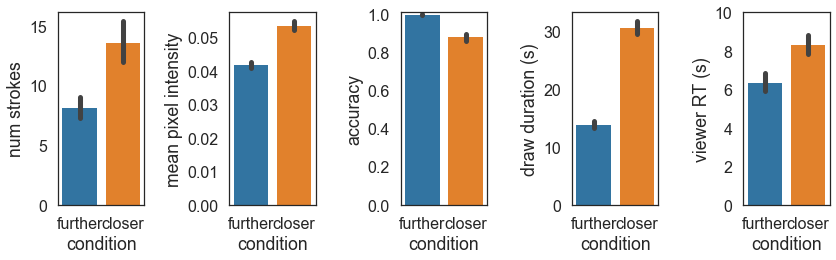

In [111]:
plt.figure(figsize=(12,4))
plt.subplot(1,5,1)
ax = sns.barplot(data=D,x='condition',y='numStrokes')
plt.ylabel('num strokes')
plt.subplot(1,5,2)
sns.barplot(data=D,x='condition',y='mean_intensity')
plt.ylabel('mean pixel intensity')
plt.subplot(1,5,3)
sns.barplot(data=D,x='condition',y='outcome')
plt.ylabel('accuracy')
plt.ylim([0,1.01])
plt.subplot(1,5,4)
sns.barplot(data=D,x='condition',y='drawDuration')
plt.ylabel('draw duration (s)')
plt.subplot(1,5,5)
ax = sns.barplot(data=D,x='condition',y='viewerRT')
plt.ylabel('viewer RT (s)')
plt.ylim(0,10)
plt.tight_layout()
if not os.path.exists('./plots'):
    os.makedirs('./plots')
plt.savefig('./plots/sketchpad_basic_pilot2_taskperformance.pdf')
plt.savefig('../manuscript/figures/raw/sketchpad_basic_taskperformance.pdf')

In [317]:
len(np.unique(D.gameID.values))

93

In [ ]:
## bootstrapped CI's on main task performance measures
boot, p, lb, ub = bootstrap(closer_strokes - further_strokes)
print p,lb,ub

boot, p, lb, ub = bootstrap(closer_meanintensity - further_meanintensity)
print p,lb,ub

boot, p, lb, ub = bootstrap(closer_drawDuration - further_drawDuration)
print p,lb,ub

boot, p, lb, ub = bootstrap(closer_drawDuration - further_drawDuration)
print p,lb,ub

boot, p, lb, ub = bootstrap(closer_viewerRT - further_viewerRT)
print p,lb,ub

In [ ]:
fig = plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
lb = 0
ub = 24
plt.plot([lb,ub],[lb,ub],'k--')
plt.scatter(closer_strokes,further_strokes,64,(0.8,0.4,0.4))
plt.xlim([lb,ub])
plt.ylim([lb,ub])
plt.title('number of strokes')
plt.xlabel('closer')
plt.ylabel('further')
plt.subplot(2,2,2)
lb = 0
ub = 3000
plt.plot([lb,ub],[lb,ub],'k--')
plt.scatter(closer_svgLength,further_svgLength,64,(0.8,0.4,0.4))
plt.xlim([lb,ub])
plt.ylim([lb,ub])
plt.tight_layout()
plt.title('svg string length')
plt.xlabel('closer')
plt.ylabel('further')
plt.subplot(2,2,3)
lb = 0
ub = 300
plt.plot([lb,ub],[lb,ub],'k--')
plt.scatter(closer_svgStd,further_svgStd,64,(0.8,0.4,0.4))
plt.xlim([lb,ub])
plt.ylim([lb,ub])
plt.title('stroke variability')
plt.xlabel('closer')
plt.ylabel('further')
plt.subplot(2,2,4)
lb = 0
ub = 300
plt.plot([lb,ub],[lb,ub],'k--')
plt.scatter(closer_svgLengthPS,further_svgLengthPS,64,(0.8,0.4,0.4))
plt.xlim([lb,ub])
plt.ylim([lb,ub])
plt.tight_layout()
plt.title('svg length per stroke')
plt.xlabel('closer')
plt.ylabel('further')
save_out = 1
if not os.path.exists('plots'):
    os.makedirs('plots')
if save_out:
    save('plots/svg_summary_scatter_{}'.format(iterationName), ext='pdf', close=False, verbose=True)

In [ ]:
fig = plt.figure(figsize=(8,4))
lb = 0
ub = 1.03
plt.subplot(1,2,1)
plt.plot([lb,ub],[lb,ub],'k--')
plt.scatter(closer_accuracy,further_accuracy,64,(0.8,0.4,0.4))
plt.xlim([lb,ub])
plt.ylim([lb,ub])
plt.title('accuracy')
plt.xlabel('closer')
plt.ylabel('further')
plt.subplot(1,2,2)
lb = 0
ub = 36
plt.plot([lb,ub],[lb,ub],'k--')
plt.scatter(closer_drawDuration,further_drawDuration,64,(0.75,0.3,0.2))
plt.xlim([lb,ub])
plt.ylim([lb,ub])
plt.title('draw duration')
plt.xlabel('closer')
plt.ylabel('further')
plt.tight_layout()
save_out = 1
if save_out:
    save('plots/performance_summary_scatter_{}'.format(iterationName), ext='pdf', close=False, verbose=True)

In [ ]:
def get_canonical(category):    
    stimFile = os.path.join(exp_dir,'stimList_subord.js')
    with open(stimFile) as f:
        stimList = json.load(f)    
    allviews = [i['filename'] for i in stimList if i['basic']==category]
    canonical = [a for a in allviews if a[-8:]=='0035.png']    
    return canonical

def get_actual_pose(subordinate,pose):
    stimFile = os.path.join(exp_dir,'stimList_subord.js')
    with open(stimFile) as f:
        stimList = json.load(f)
    inpose = [i['filename'] for i in stimList if (i['subordinate']==subordinate) and (i['pose']==pose)]
    return inpose
    
def get_subord_names(category):
    full_names = get_canonical(category)    
    return [c.split('_')[2] for c in full_names]

def get_basic_names(subordinate):
    stimFile = os.path.join(exp_dir,'stimList_subord.js')
    with open(stimFile) as f:
        stimList = json.load(f)   
    allviews = [i['filename'] for i in stimList if i['subordinate']==subordinate]
    canonical = [a for a in allviews if a[-8:]=='0035.png']      
    return canonical[0].split('_')[0]

def build_url_from_category(category):
    full_names = get_canonical(category)
    url_prefix = 'https://s3.amazonaws.com/sketchloop-images-subord/'
    urls = []
    for f in full_names:
        urls.append(url_prefix + f)
    return urls

def build_url_from_filenames(filenames):
    url_prefix = 'https://s3.amazonaws.com/sketchloop-images-subord/'
    urls = []
    for f in filenames:
        urls.append(url_prefix + f)
    return urls

def plot_from_url(URL):
    file = cStringIO.StringIO(urllib.urlopen(URL).read())
    img = Image.open(file)    

def plot_gallery(category):
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec

    plt.figure(figsize = (8,8))
    gs1 = gridspec.GridSpec(8, 8)
    gs1.update(wspace=0.025, hspace=0.05)

    url_prefix = 'https://s3.amazonaws.com/sketchloop-images-subord/'
    for (i,c) in enumerate(category):
        URL = url_prefix + c
        file = cStringIO.StringIO(urllib.urlopen(URL).read())
        img = Image.open(file)
        p = plt.subplot(3,3,i+1)
        plt.imshow(img)
        p.get_xaxis().set_ticklabels([])
        p.get_yaxis().set_ticklabels([])
        p.get_xaxis().set_ticks([])
        p.get_yaxis().set_ticks([])
        p.set_aspect('equal')
        subord = c.split('_')[2]
        plt.title(subord)
    plt.tight_layout()
    

In [ ]:
## print out sketches with target & distractors from this game
import traceback
backup_path_images = '/Users/judithfan/Dropbox/stimuli_repository/subordinate_allrotations_6_minified'

_valid_gameids = valid_gameids[:3]

## get list of all incorrect sketch path names
incorrect_trial_paths = []

run_this = 0
if run_this:
#     all_games = click_files
    for g in valid_gameids:
        print 'Printing out sketches from game: ' + g
        _D = D[(D.gameID==g)]
        _D = _D.sort_values(by=['target'])
        _i = 1
        textsize=12
        fig = plt.figure(figsize=(16,6))        
        for i,_d in _D.iterrows():
            imgData = _d['png']
            filestr = base64.b64decode(imgData)
            target_sketch_dir = os.path.join(analysis_dir,'sketches_pilot2','sketch')
            if not os.path.exists(target_sketch_dir):
                os.makedirs(target_sketch_dir)
            fname = os.path.join(target_sketch_dir,'gameID_' + _d['gameID'] + '_trial_' + str(_d['trialNum']) + '.png')
            with open(fname, "wb") as fh:
                fh.write(imgData.decode('base64'))
            textsize = 16
            # first plot the target
            im = Image.open(fname)
            p = plt.subplot(2,4,1)
            plt.imshow(im)
            sns.set_style('white')
            k = p.get_xaxis().set_ticklabels([])
            k = p.get_yaxis().set_ticklabels([])
            k = p.get_xaxis().set_ticks([])
            k = p.get_yaxis().set_ticks([])        
            targetname = _d['target']
            distractors = [_d['Distractor1'],_d['Distractor2'],_d['Distractor3']]
            full_list = [_d['target'],_d['Distractor1'],_d['Distractor2'],_d['Distractor3']] 
            outcome = _d['outcome']
            if _d['outcome']==0:
                incorrect_trial_paths.append('gameID_' + _d['gameID'] + '_trial_' + str(_d['trialNum']) + '_' + _d['target'] + '.png')            
                        
            response = _d['response']        
            if outcome == 1:
                sides = ['bottom','top','right','left']
                for s in sides:
                    p.spines[s].set_color((0.4,0.8,0.4))
                    p.spines[s].set_linewidth(4)                               
            else:
                sides = ['bottom','top','right','left']
                for s in sides:
                    p.spines[s].set_color((0.9,0.2,0.2))
                    p.spines[s].set_linewidth(4)                      
            plt.title(targetname,fontsize=textsize)
            plt.ylabel('v:' + response,fontsize=textsize-2)        
        
            # fig = plt.figure(figsize=(8,3))
            for (i,d) in enumerate(full_list):
                if os.path.exists(backup_path_images):
                    if hasattr(t, 'pose'):
                        fn = os.path.join(backup_path_images,get_actual_pose(d,pose)[0])
                    else:
                        fn = os.path.join(backup_path_images,get_actual_pose(d,35)[0])
                else:
                    if hasattr(t, 'pose'):
                        pose = t['pose']
                        URL = build_url_from_filenames(get_actual_pose(d,pose)[0])
                    else:
                        URL = full_dict[d]
                    fn = cStringIO.StringIO(urllib.urlopen(URL).read())
                img = Image.open(fn)
                p = plt.subplot(2,4,i+5)
                plt.imshow(img)
                p.get_xaxis().set_ticklabels([])
                p.get_yaxis().set_ticklabels([])
                p.get_xaxis().set_ticks([])
                p.get_yaxis().set_ticks([])
                p.set_aspect('equal')   
                plt.title(d)

            sketch_dir = os.path.join(analysis_dir,'sketches_pilot2','full_display')
            if not os.path.exists(sketch_dir):
                os.makedirs(os.path.join(analysis_dir,'sketches_pilot2','full_display'))
            filepath = os.path.join(sketch_dir,'gameID_' + _d['gameID'] + '_trial_' + str(_d['trialNum']))
            save(filepath, ext='png', close=True, verbose=False)

In [ ]:
## save out number of incorrect trial paths
print "Number of incorrect trial paths: {}".format(str(len(incorrect_trial_paths)))
with open('incorrect_trial_paths_pilot2.txt', 'w') as f:
    for path in incorrect_trial_paths:
        f.write(path + '\n')

### Print out sketches in separate folders

In [ ]:
## print out sketches with target & distractors from this game in separate folders
import traceback
backup_path_images = '/Users/judithfan/Dropbox/stimuli_repository/subordinate_allrotations_6_minified'

_valid_gameids = valid_gameids[:3]

target_sketch_dir = os.path.join(analysis_dir,'sketches_pilot2','sketch')
target_3D_dir = os.path.join(analysis_dir,'sketches_pilot2','target')
distractor1_3D_dir = os.path.join(analysis_dir,'sketches_pilot2','distractor1')
distractor2_3D_dir = os.path.join(analysis_dir,'sketches_pilot2','distractor2')
distractor3_3D_dir = os.path.join(analysis_dir,'sketches_pilot2','distractor3')
out_paths = [target_3D_dir,distractor1_3D_dir,distractor2_3D_dir,distractor3_3D_dir]


if not os.path.exists(target_3D_dir):
    os.makedirs(os.path.join(analysis_dir,'sketches_pilot2','target'))
    os.makedirs(os.path.join(analysis_dir,'sketches_pilot2','distractor1'))
    os.makedirs(os.path.join(analysis_dir,'sketches_pilot2','distractor2'))
    os.makedirs(os.path.join(analysis_dir,'sketches_pilot2','distractor3'))
    os.makedirs(os.path.join(analysis_dir,'sketches_pilot2','sketch'))    

run_this = 1
if run_this:
    for g in valid_gameids:
        print 'Printing out sketches from game: ' + g
        _D = D[(D.gameID==g)]
        _D = _D.sort_values(by=['target'])
        _i = 1
        textsize=12
        fig = plt.figure(figsize=(16,6))        
        for i,_d in _D.iterrows():
            imgData = _d['png']
            filestr = base64.b64decode(imgData)
            if not os.path.exists(target_sketch_dir):
                os.makedirs(target_sketch_dir)
            fname = os.path.join(target_sketch_dir,'gameID_' + _d['gameID'] + '_trial_' + str(_d['trialNum']) + '.png')
            with open(fname, "wb") as fh:
                fh.write(imgData.decode('base64'))
            im = Image.open(fname)
            im.save(fname)

            targetname = _d['target']
            distractors = [_d['Distractor1'],_d['Distractor2'],_d['Distractor3']]
            full_list = [_d['target'],_d['Distractor1'],_d['Distractor2'],_d['Distractor3']]         
            
            for (i,d) in enumerate(full_list):
                if os.path.exists(backup_path_images):
                    if hasattr(t, 'pose'):
                        fn = os.path.join(backup_path_images,get_actual_pose(d,pose)[0])
                    else:
                        fn = os.path.join(backup_path_images,get_actual_pose(d,35)[0])
                else:
                    if hasattr(t, 'pose'):
                        pose = _d['pose']
                        URL = build_url_from_filenames(get_actual_pose(d,pose)[0])
                    else:
                        URL = full_dict[d]
                    fn = cStringIO.StringIO(urllib.urlopen(URL).read())
                fig = plt.figure(figsize=(8,8))                    
                im = Image.open(fn)
                im = im.resize((256,256), Image.ANTIALIAS).convert('RGB')                                
                out_dirs = [target_3D_dir,distractor1_3D_dir,distractor2_3D_dir,distractor3_3D_dir]                
                out_path = os.path.join(out_dirs[i],'gameID_' + _d['gameID'] + '_trial_' + str(_d['trialNum']) + '_' + d + '.png')
                im.save(out_path)



## Load in data again to prep for model comparison

In [3]:
D = pd.read_csv(os.path.join(analysis_dir,'sketchpad_basic_pilot2_group_data.csv'))
DUNFIL = pd.read_csv(os.path.join(analysis_dir,'sketchpad_basic_pilot2_group_data_unfiltered.csv'))

# filter out incorrect and invalid trials as well
incorrects = pd.read_csv('./incorrect_trial_paths_pilot2.txt',header=None)[0].values
invalids = pd.read_csv('./invalid_trial_paths_pilot2.txt',header=None)[0].values

def add_fnames(D):
    fname = []
    for i,_d in D.iterrows():
        fname.append('gameID_' + _d['gameID'] + '_trial_' + str(_d['trialNum']) + '_' + _d['target'] +'.png')    
    D = D.assign(fname=pd.Series(fname).values)  

    fname_no_target = []
    for i,_d in D.iterrows():
        fname_no_target.append('gameID_' + _d['gameID'] + '_trial_' + str(_d['trialNum']) +'.png')    
    D = D.assign(fname_no_target=pd.Series(fname_no_target).values) 
    return D

def filter_out_incorrect(D, incorrects):
    D = D[~D['fname'].isin(incorrects)]
    return D

def filter_out_invalids(D, invalids):
    D = D[~D['fname_no_target'].isin(invalids)] 
    return D
    
## add some filename columns
D = add_fnames(D)
DUNFIL = add_fnames(DUNFIL) ## version of dataframe with ALL trials, garbage games, incorrect trials, invalid trials

DNOINC = filter_out_incorrect(DUNFIL, incorrects) ## save version of D containing with incorrect trials filtered out only
DNOINV = filter_out_invalids(DUNFIL, invalids) ## save version of D containing with invalid trials filtered out only
D = filter_out_invalids(filter_out_incorrect(D, incorrects), invalids) ## both kinds of garbage filtered out

print np.shape(D)
print str(np.shape(D)[0]) + ' records in merged dataframe'

print '{} incorrect trials'.format(len(incorrects))
print '{} invalid trials'.format(len(invalids))

(2682, 24)
2682 records in merged dataframe
194 incorrect trials
132 invalid trials


In [4]:
print '{} trials with NO GARBAGE filtered out'.format(DUNFIL.shape[0])
print '{} trials with incorrects filtered out'.format(DNOINC.shape[0])
print '{} trials with invalids filtered out'.format(DNOINV.shape[0])
print '{} trials with ALL GARBAGE filtered out'.format(D.shape[0])

3072 trials with NO GARBAGE filtered out
2878 trials with incorrects filtered out
2940 trials with invalids filtered out
2682 trials with ALL GARBAGE filtered out


In [5]:
## now assign sketch_label and class_label for the other versions of D
def add_extra_label_columns(D):
    sketch_label = [(i[-12:] + '_' + str(j)) for i,j in zip(D['gameID'].values,D['trialNum'].values)]
    D = D.assign(sketch_label=pd.Series(sketch_label).values)

    # add class label
    category = []
    classes = ['bird','car','chair','dog']
    for i,d in D.iterrows():
        category.append(h.objcat[d['target']])
    D = D.assign(category=pd.Series(category).values)
    return D

D = add_extra_label_columns(D)
DUNFIL = add_extra_label_columns(DUNFIL)
DNOINC = add_extra_label_columns(DNOINC)
DNOINV = add_extra_label_columns(DNOINV)

### Visualize distance distributions

In [17]:
##### this block is just to generate the lookup table for sketch ID's, e.g., {'trial_10_beetle': u'beetle'}
path_to_dists = './strict-similarity-pragmatics-fixedpose-augmented-splitbycontext_conv4_2.json'
#### path_to_dists = '../models/refModule/json/similarity-splitbyobject-sketch_unroll_synthetic.json'
_dists = pd.read_json(path_to_dists)
dists = _dists.transpose()
x = _dists.columns.values
y = [i.split('_')[-1] for i in x]
lookup_table = dict(zip(y,x))
reverse_lookup = dict(zip(x,y))

In [68]:
_d['sketch_label']

'd6a8931c94d5_1'

In [69]:
reallyRun = 0
if reallyRun:
    dT = []
    dD1 = []
    dD2 = []
    dD3 = []
    for i, _d in D.iterrows():
        sketch = _d['sketch_label']
        pose = int(_d['pose'])
        target = lookup_table[_d['target']]
        distractor1 = lookup_table[_d['Distractor1']]
        distractor2 = lookup_table[_d['Distractor2']]
        distractor3 = lookup_table[_d['Distractor3']]

        dT.append(dists[sketch][target])
        dD1.append(dists[sketch][distractor1])
        dD2.append(dists[sketch][distractor2])
        dD3.append(dists[sketch][distractor3])
        
    D = D.assign(dT=pd.Series(dT).values)
    D = D.assign(dD1=pd.Series(dD1).values)
    D = D.assign(dD2=pd.Series(dD2).values)
    D = D.assign(dD3=pd.Series(dD3).values)        

In [ ]:
# filter out training examples
# test_examples = pd.read_csv('./pilot2_augmented2_test_examples.txt',header=None)[0].values
# test_examples = [i.split('.')[0] + '.png' for i in test_examples]

In [ ]:
sns.set_context('talk')
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
_D = D[(D.condition=='closer') & (D['fname'].isin(test_examples))]
distractor_dists = np.hstack((_D.dD1.values,_D.dD2.values,_D.dD3.values))
sns.kdeplot(distractor_dists, shade=True, color=(0.3,0.3,0.3),label='distractors')
sns.kdeplot(_D.dT.values, shade=True, color=(0.9,0.7,0.1),label='target')
plt.ylim([0,7])
plt.xlim([-1,1])
plt.xlabel('distance')
plt.title('close')

plt.subplot(1,2,2)
_D = D[(D.condition=='further') & (D['fname'].isin(test_examples))]
distractor_dists = np.hstack((_D.dD1.values,_D.dD2.values,_D.dD3.values))
sns.kdeplot(distractor_dists, shade=True, color=(0.3,0.3,0.3),label='distractors')
sns.kdeplot(_D.dT.values, shade=True, color=(0.9,0.7,0.1),label='target')
plt.ylim([0,7])
plt.xlim([-1,1])
plt.xlabel('distance')
plt.title('far')

plt.suptitle('fixedpose - augmented - splitbycontext - test')

In [ ]:
sns.set_context('talk')
plt.figure(figsize=(12,12))
for i,cl in enumerate(classes):
    plt.subplot(2,2,i+1)
    _D = D[(D['fname'].isin(test_examples)) & (D['category']==cl)]
    distractor_dists = np.hstack((_D.dD1.values,_D.dD2.values,_D.dD3.values))
    sns.kdeplot(distractor_dists, shade=True, color=(0.3,0.3,0.3),label='distractors')
    sns.kdeplot(_D.dT.values, shade=True, color=(0.9,0.7,0.1),label='target')
    plt.ylim([0,7])
    plt.xlim([-1,1])
    if i>1:
        plt.xlabel('distance')
    plt.title('{}'.format(cl))

### Preprocessing to make bdaInput csv

In [97]:
path_to_dists = './strict-similarity-pragmatics-fixedpose-augmented-splitbycontext_conv4_2.json'
_dists = pd.read_json(path_to_dists)
dists = _dists.transpose()
x = _dists.columns.values
y = [i.split('_')[-1] for i in x]
lookup_table = dict(zip(y,x))
reverse_lookup = dict(zip(x,y))

In [98]:
### filter out training examples ### NEW SPLIT ON OBJECT 4/23/2018
test_examples = pd.read_json('pilot2_sketch_avg_full25k_test_examples.json',orient='records')
test_examples = list(test_examples[0].values)
test_examples = [i.split('.')[0] + '.png' for i in test_examples] 
print '{} test examples.'.format(len(np.unique(test_examples)))

608 test examples.


In [101]:
def generate_bdaInput_csv(D,filtration_level,train_test_split=True,
                          adaptor_type='sketch_avg_full25k',
                          split_type='splitbyobject'):
#     # filter out training examples #### OLD SPLIT ON CONTEXT MAY REUSE
#     test_examples = pd.read_csv('./pilot2_augmented_splitbycontext_test_examples.txt',header=None)[0].values
#     test_examples = [i.split('.')[0] + '.png' for i in test_examples]
    
    ### filter out training examples ### NEW SPLIT ON OBJECT 4/23/2018
    test_examples = pd.read_json('pilot2_{}_test_examples.json'.format(adaptor_type),orient='records')
    test_examples = list(test_examples[0].values)
    test_examples = [i.split('.')[0] + '.png' for i in test_examples]    

    if train_test_split==True:
        keep_examples = test_examples 
    else:
        keep_examples = D['fname_no_target'].values ## keep all datapoints

    D0 = D[D['fname_no_target'].isin(keep_examples)]
    print('Shape of D0: {}'.format(D0.shape))

    ## generate lists to compose new bdaInput CSV
    _sketchLabel = []
    _Condition = []
    _Target = []
    _Distractor1 = []
    _Distractor2 = []
    _Distractor3 = []
    _coarseGrainedSketchInfo = [] # condition_objectName ... e.g., further_knob
    for i, _d in D0.iterrows():
        _sketchLabel.append(_d['sketch_label'])
        _Condition.append(_d['condition']) 
        ###### in more recent versions of similarity jsons, dropping the weird trial_20_basset thing
#         _Target.append(lookup_table[_d['target']])
#         distractor1 = lookup_table[_d['Distractor1']]
#         distractor2 = lookup_table[_d['Distractor2']]
#         distractor3 = lookup_table[_d['Distractor3']]
        _Target.append(_d['target'])
        distractor1 = _d['Distractor1']
        distractor2 = _d['Distractor2']
        distractor3 = _d['Distractor3']      
        
        d_list = sorted([distractor1, distractor2, distractor3])
        _Distractor1.append(d_list[0])
        _Distractor2.append(d_list[1])    
        _Distractor3.append(d_list[2])  
        _coarseGrainedSketchInfo.append('{}_{}'.format(_d['condition'],_d['target'])) 

    D2 = pd.DataFrame([_Condition,_sketchLabel,_Target,_Distractor1,_Distractor2,_Distractor3,_coarseGrainedSketchInfo])
    D2 = D2.transpose()
    D2.columns = ['condition','sketchLabel','Target','Distractor1','Distractor2','Distractor3','coarseGrainedSketchInfo']
    print D2.shape
    if train_test_split==True:
        print 'saving CSV with only test data'
        if len(filtration_level)==0:
            D2.to_csv('../models/bdaInput/sketchData_fixedPose_{}_{}_pilot2.csv'.format(split_type,adaptor_type))
        else:  
            D2.to_csv('../models/bdaInput/sketchData_fixedPose_{}_{}_pilot2_{}.csv'.format(split_type,adaptor_type,filtration_level))
    else: ## run bda on ALL datapoints (not just test split)
        print 'saving CSV including all datapoints'
        if len(filtration_level)==0:
            D2.to_csv('../models/bdaInput/sketchData_fixedPose_alldata_{}_pilot2.csv'.format(adaptor_type))
        else:  
            D2.to_csv('../models/bdaInput/sketchData_fixedPose_alldata_{}_pilot2_{}.csv'.format(adaptor_type,filtration_level))        
    print 'Saved out bdaInput CSV ... {}'.format(filtration_level) 

In [102]:
generate_bdaInput_csv(D,'')
generate_bdaInput_csv(DNOINC,'no_incorrect')
generate_bdaInput_csv(DNOINV,'no_invalid')
generate_bdaInput_csv(DUNFIL,'unfiltered')

Shape of D0: (544, 29)
(544, 7)
saving CSV with only test data
Saved out bdaInput CSV ... 
Shape of D0: (573, 24)
(573, 7)
saving CSV with only test data
Saved out bdaInput CSV ... no_incorrect
Shape of D0: (574, 24)
(574, 7)
saving CSV with only test data
Saved out bdaInput CSV ... no_invalid
Shape of D0: (608, 24)
(608, 7)
saving CSV with only test data
Saved out bdaInput CSV ... unfiltered


In [103]:
generate_bdaInput_csv(D,'',train_test_split=False)
generate_bdaInput_csv(DNOINC,'no_incorrect',train_test_split=False)
generate_bdaInput_csv(DNOINV,'no_invalid',train_test_split=False)
generate_bdaInput_csv(DUNFIL,'unfiltered',train_test_split=False)

### jefan note: to remove cost outliers, go to pilot2_analysis_sketchpad_basic_recog.ipynb

Shape of D0: (2682, 29)
(2682, 7)
saving CSV including all datapoints
Saved out bdaInput CSV ... 
Shape of D0: (2878, 24)
(2878, 7)
saving CSV including all datapoints
Saved out bdaInput CSV ... no_incorrect
Shape of D0: (2940, 24)
(2940, 7)
saving CSV including all datapoints
Saved out bdaInput CSV ... no_invalid
Shape of D0: (3072, 24)
(3072, 7)
saving CSV including all datapoints
Saved out bdaInput CSV ... unfiltered


## Model comparison

In [ ]:
def sumlogprob(a,b):
    if (a > b):
        return a + np.log1p(np.exp(b-a))
    else:
        return b + np.log1p(np.exp(a-b))    

In [ ]:
which_feat = 'fixedpose_aug2_alldata'

if which_feat == 'varypose_nonaug':
    P = pd.read_csv('./RSA/bdaOutput/testingParams_alldata.csv')
elif which_feat == 'fixedpose_nonaug_closeonly':
    P = pd.read_csv('./RSA/bdaOutput/testingParams_closeonly_fixedpose.csv')
elif which_feat == 'fixedpose_aug_closeonly':
    P = pd.read_csv('./RSA/bdaOutput/testingParams_closeonly_fixedpose_augmented.csv')
elif which_feat == 'fixedpose_aug2_alldata':
    P = pd.read_csv('./RSA/bdaOutput/testingParams_testdata_fixedpose_augmented2.csv')
    
# filter out rows where posterior probability is -Infinity
# P = P[P.posteriorProb!='-Infinity']
print np.shape(P)colo

X = P.groupby(['similarityMetric', 'speakerModel'])['logLikelihood']
Y = X
Y = pd.DataFrame(Y)

sns.set_context('poster')
colors = sns.color_palette("Paired")
fig = plt.figure(figsize=(26,8))
seq = [('strict-mid-pragmatics-augmented2','S0'),('strict-mid-pragmatics-augmented2','S1'),('nonstrict-high-sketchy','S0'),('nonstrict-high-sketchy','S1')]
sns.barplot(data=Y.transpose(),palette=colors, order = seq)
# plt.ylim([-1400,-600])
plt.ylabel('log likelihood')
plt.title('model comparison: all test data',fontsize=24)
plt.show()

In [ ]:
# P = pd.read_csv('./RSA/bdaOutput/testingParams_testdata_fixedpose.csv')
# # filter out rows where posterior probability is -Infinity
# # P = P[P.posteriorProb!='-Infinity']
# print np.shape(P)

# X = P.groupby(['similarityMetric', 'speakerModel'])['logLikelihood']
# Y = X.apply(lambda x: reduce(sumlogprob,x) - np.log(len(x)))
# Y = pd.DataFrame(Y)

# sns.set_context('talk')
# colors = sns.color_palette("Paired")
# fig = plt.figure(figsize=(16,4))
# seq = [('strict-mid-pragmatics-augmented','S0'),('strict-mid-pragmatics-augmented','S1'),('strict-mid-pragmatics','S0'),('strict-mid-pragmatics','S1'),('nonstrict-high-sketchy','S0'),('nonstrict-high-sketchy','S1')]
# sns.barplot(data=Y.transpose(),palette=colors, order = seq)
# plt.ylim([-9000,-8000])
# plt.ylabel('log likelihood')
# plt.title('model comparison: held out data (majority far trials)',fontsize=24)
# plt.show()

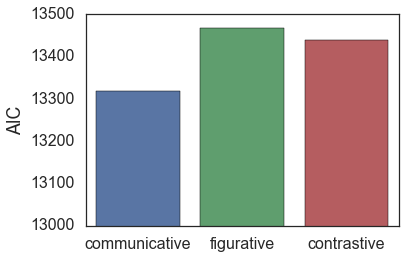

In [203]:
### latest set of S1/S0 model log-likelihoods

combined= -6658
S1= -6720
S0= -6734

S0_AIC = -2*S0
S1_AIC = -2*S1
combined_AIC = 2 - 2*combined

LL = pd.DataFrame([combined,S0,S1])
LL = LL.transpose()
LL.columns = ['communicative','figurative','contrastive']

AIC = pd.DataFrame([combined_AIC,S0_AIC,S1_AIC])
AIC = AIC.transpose()
AIC.columns = ['communicative','figurative','contrastive']


fig = plt.figure(figsize=(6,4))
plt.subplot(111)
sns.barplot(data=AIC)
plt.ylim([13000,13500])
plt.ylabel('AIC')
plt.tight_layout()
plt.savefig('./plots/model_comparison_for_vss_abstract.pdf')

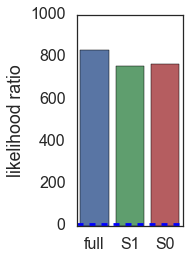

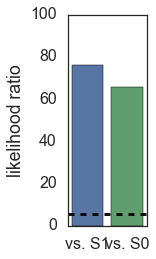

In [34]:
### latest set of S1/S0 model log-likelihoods

full = pd.read_csv('../models/bdaOutput/combined_MCMC_mid-layer-augmented_wcostParamsParams.csv')
S1 = pd.read_csv('../models/bdaOutput/S1_MCMC_mid-layer-augmented_wcostParamsParams.csv')
S0 = pd.read_csv('../models/bdaOutput/S0_MCMC_mid-layer-augmented_wcostParamsParams.csv')
null = pd.read_csv('../models/bdaOutput/combined_MCMC_early-layer_wcostParamsParams.csv')

# likelihood ratio
full_like = full['logLikelihood'].values[0]
S1_like = S1['logLikelihood'].values[0]
S0_like = S0['logLikelihood'].values[0]
null_like = null['logLikelihood'].values[0]

full_null = full_like - null_like
S1_null = S1_like - null_like
S0_null = S0_like - null_like
full_S1 = full_like - S1_like
full_S0 = full_like - S0_like

LR = pd.DataFrame([full_null,S1_null,S0_null])
LR = LR.transpose()
LR.columns = ['full','S1','S0']

LR2 = pd.DataFrame([full_S1, full_S0])
LR2 = LR2.transpose()
LR2.columns = ['vs. S1', 'vs. S0']

from scipy.stats import chi2
crit_val = chi2.isf(q=0.001, df=1) / 2 ## because we are plotting raw Likelihood Ratio, instead of 2*LR, which follows chisquare

fig = plt.figure(figsize=(3,4))
plt.subplot(111)
sns.barplot(data=LR)
plt.axhline(y=crit_val,ls='dashed')
plt.ylabel('likelihood ratio')
plt.ylim([0,1000])
plt.tight_layout()
plt.savefig('./plots/model_comparison_for_january_talks_vsnull.pdf')

fig = plt.figure(figsize=(2.5,4))
plt.subplot(111)
sns.barplot(data=LR2)
plt.axhline(y=crit_val,ls='dashed',color=(0,0,0))
plt.ylim([0,100])
plt.ylabel('likelihood ratio')
plt.tight_layout()
plt.savefig('./plots/model_comparison_for_january_talks_vsS1S0.pdf')

## Analyzing RDMs

In [241]:
x = np.load('rdm_triplet_random_negatives.npy')
labels = np.load('triplet_rdm_axis_labels.npy')
close = x[:32,32:64]
far = x[:32,64:96]

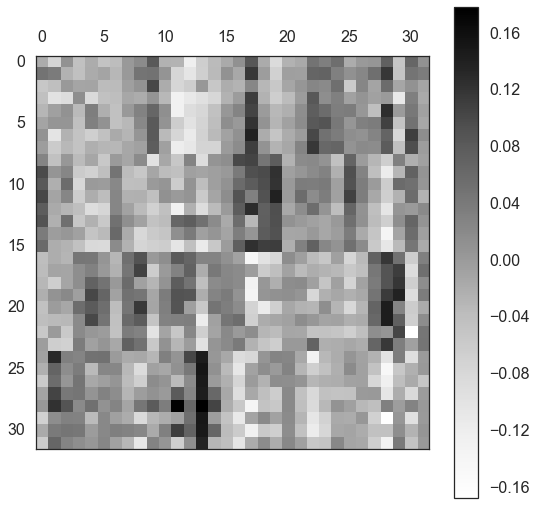

In [242]:
plt.matshow(close-far)
plt.colorbar()

In [285]:
## get contrast between on-diagonal and other elements in the column
from __future__ import division
def softmax(x):
    denom = np.sum(map(np.exp,x))
    return [i/denom for i in x]
        
def get_superblock_bounds(M_shape,block_size):
    bounds = np.linspace(0,M_shape,M_shape/block_size+1)
    bound_tuples = []
    for i,j in enumerate(bounds[:len(bounds)-1]):
        bound_tuples.append(tuple((int(bounds[i]), np.int(bounds[i+1]))))
    return bound_tuples

    
def get_superblocks(M,num_cats):
    '''
    accepts: 
        square similarity matrix M of dim (m,m)
        num_cats: number of categories (dim of superblock is m/num_cats)
    '''
    M_shape = M.shape[0]
    block_size = M_shape/num_cats
    bound_tuples = get_superblock_bounds(M_shape,block_size)
    _M = []
    for block in bound_tuples:
        _M.append(M[block[0]:block[1]])
        

In [286]:
bound_tuples = get_superblock_bounds(32,8)
_M = []
for block in bound_tuples:
    _M.append(M[block[0]:block[1]])
# print _M

[array([[ 0.88933742,  0.656222  ,  0.84275024,  0.614339  ,  0.65271597,
         0.66089313,  0.70622475,  0.70143999, -0.17178838, -0.17493993,
        -0.31190633, -0.29600326, -0.48622522, -0.38795748, -0.3686948 ,
        -0.19630455, -0.11920085, -0.10966624, -0.26509653, -0.33197405,
        -0.19296392, -0.22173388, -0.14703464, -0.04047838, -0.41726085,
        -0.34105312, -0.23217916, -0.14078966, -0.05733335, -0.23960213,
        -0.14274601, -0.1726628 ],
       [ 0.61021243,  0.90466361,  0.60323999,  0.53226391,  0.75735665,
         0.67417391,  0.610182  ,  0.62451166, -0.17881535, -0.24652286,
        -0.28453616, -0.39774374, -0.37132643, -0.48461393, -0.46091663,
        -0.28497298, -0.10220365,  0.01624705, -0.12369626, -0.16298476,
        -0.0237127 , -0.11587892, -0.02163459,  0.24681852, -0.34862329,
        -0.29434134, -0.31403347, -0.21515299, -0.14724607, -0.37414661,
        -0.25446259, -0.29375385],
       [ 0.53924242,  0.51322388,  0.86172927,  0.481

/Users/judithfan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


In [283]:
x = bound_tuples[0]
x[0]

0.0

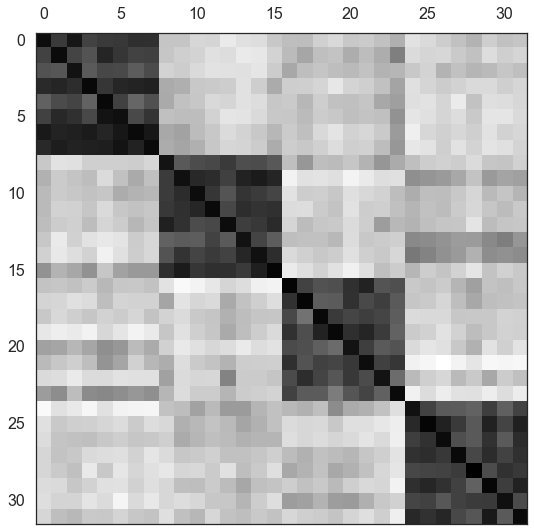

In [238]:
plt.matshow(close)

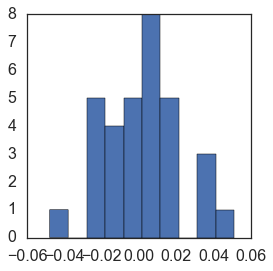

In [236]:
fig = plt.figure(figsize=(4,4))
h = plt.hist(np.diag(close) - np.diag(far))

In [6]:
# zip(labels[:32],np.diag(close) - np.diag(far))

In [7]:
# plt.plot(np.arange(32),np.diag(close) - np.diag(far))

In [8]:
# x = np.diag(close) - np.diag(far)

In [9]:
# np.where(x<0)

In [10]:
# def compare_on_vs_off(mat):

In [11]:
# np.diag(close)

In [12]:
# plt.hist(np.diag(far))